# Package installation

Install any necessary software into the Julia installation. Note that this is only
necessary onces after installing Julia. 

In [ ]:
import Pkg

Pkg.add("StatsBase") # Necessary functions like `mean` and `std`
Pkg.add("Distributions") # Necessary for bivariate gaussian distribtions
Pkg.add("Revise") # Convienent for modifications
Pkg.add("PyPlot") # Necessary for plotting
Pkg.add("HDF5") # Necessary for data loading
Pkg.add("LinearAlgebra") # Necessary for linear algebra functions

# Module and data loading

In [1]:
using Revise
using StatsBase
using Distributions
using PyPlot
using LinearAlgebra
import HDF5

# Include our code for generating bivariate distributions
includet("src/mv_random.jl");

In [2]:
# Load our data
if ! Base.Filesystem.isfile("pairwise_covariance.h5")
    error("Expected an h5 file called pairwise_covariance in the directory $(Base.Filesystem.pwd())")
end
fp = HDF5.h5open("pairwise_covariance.h5", "r")
pairwise_covariance = fp["pairwise_pc_covariance"][]
# Remove any pair-wise covariance values that are NaN (cells are non-overlapping in time)
pairwise_covariance = pairwise_covariance[.! isnan.(pairwise_covariance)]
mean_firing_rates = fp["mean_firing_rates"][]
close(fp)

# Function definitions

In [3]:
"""
    generate_covariance_matrix(simulated_mean_firing_rates, pairwise_covariance)


Construct a num_neurons x num_neurons covariance matrix by pulling random
covariance values from an emperically found distribution of pairwise covariance
values passed in via the `pairwise_covariance` input. The number of neurons
is specified by the length of the simulated_mean_firing_rates vector.

Returns:
 - An num_neurons x num_neurons random covariance matrix 
"""
function generate_covariance_matrix(simulated_mean_firing_rates::AbstractVector{<:Real}, 
        pair_wise_covariance::AbstractVector{<:Real})
    num_neurons = length(simulated_mean_firing_rates)
    
    covariance_matrix = zeros(num_neurons, num_neurons)
    for i = 1:num_neurons
        covariance_matrix[i, i] = simulated_mean_firing_rates[i] ./ 1000
        for j = i+1:num_neurons
            rand_index = rand(1:length(pair_wise_covariance))
            covariance_matrix[i, j] = pair_wise_covariance[rand_index]
            covariance_matrix[j, i] = covariance_matrix[i, j]
        end
    end
    return covariance_matrix
end

"""
    plot_covariance_matrix(covariance_matrix)

Convenience function for plotting the num_neurons x num_neurons
covariance matrix
"""
function plot_covariance_matrix(covariance_matrix::AbstractMatrix)
    num_neurons = size(covariance_matrix, 1)
    fig = figure()
    pcolormesh(1:1:size(covariance_matrix, 1), 1:1:size(covariance_matrix, 1), covariance_matrix)
    ylim(num_neurons, 1)
    colorbar()
    clim(minimum(covariance_matrix), maximum(covariance_matrix))
    return fig
end

plot_covariance_matrix

In [4]:
"""
    mean_simultaneous_spikes(spiketrains)

    Computes the mean number of excess synchronous spikes that occur across the population
    given that one of the neurons fired. Returns the number of spikes across
    the population in the same millisecond.
"""
function mean_simultaneous_spikes(spiketrains::AbstractMatrix)
    additional_spikes_per_ms = zeros(size(spiketrains, 1))
    # Note that that the ("-1") in the below function ensures that
    # we do not count the spikes from the "trigger" neuron. We only want
    # excess spikes
    Threads.@threads for i = 1:length(additional_spikes_per_ms)
        additional_spikes_per_ms[i] = mean(sum(spiketrains[:, spiketrains[i, :] .> 0], dims=1) .- 1)
    end
    return mean(additional_spikes_per_ms)
end

mean_simultaneous_spikes

# Estimating Population synchrony via simulation

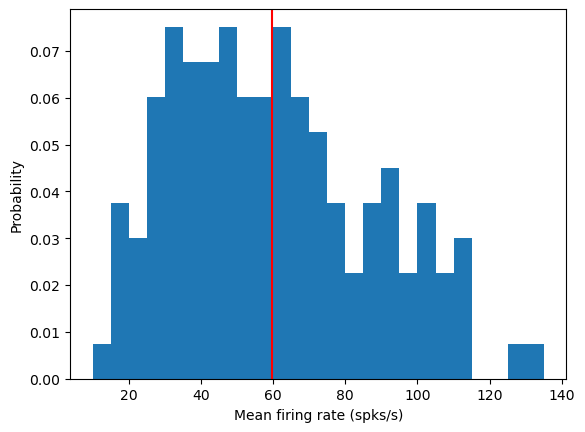

In [5]:
# Plot our distribution of mean firing rates
h = StatsBase.fit(StatsBase.Histogram, mean_firing_rates, nbins=25)
bar(h.edges[1][1:end-1] .+ diff(h.edges[1]) / 2.0, h.weights ./ sum(h.weights), mean(diff(h.edges[1])))
axvline(mean(mean_firing_rates), color="r")

xlabel("Mean firing rate (spks/s)")
ylabel("Probability");

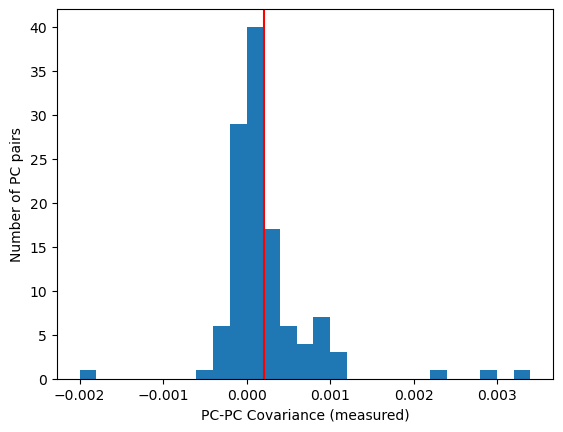

In [6]:
# Plot our distribution of pair-wise covariance matrices
h = StatsBase.fit(StatsBase.Histogram, pairwise_covariance, nbins=25)
bar(h.edges[1][1:end-1] .+ diff(h.edges[1]) / 2.0, h.weights, mean(diff(h.edges[1])))
axvline(mean(pairwise_covariance), color="r")

xlabel("PC-PC Covariance (measured)")
ylabel("Number of PC pairs");

┌ Warning: AssertionError("sign(upper_bound_value) != sign(lower_bound_value)")
└ @ Main /home/herzfeldd/projects/PCPopulationSynchrony/src/mv_random.jl:139


RMSE for simulated covariance estimation: 9.16910398630141e-5


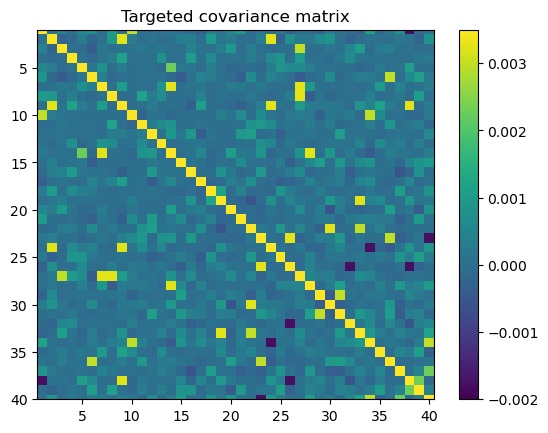

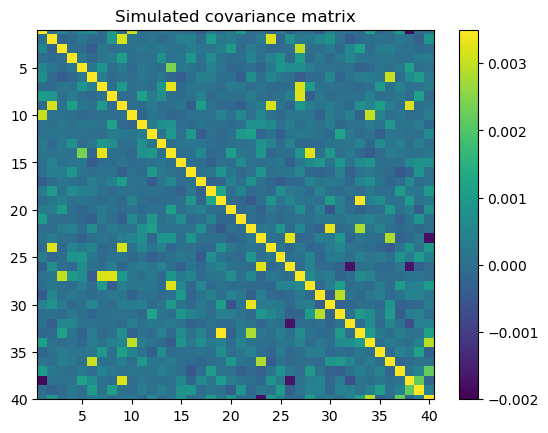

In [7]:
# Construct a simulated population by pulling values
# from our emperical firing rate distribution and pairwise covariance
# values. Note that this is just an example of a pair-wise covariance matrix.
# We actually construct >50 random populations to perform statistics on (see blow)
num_neurons = 40
simulated_firing_rates = rand(mean_firing_rates, num_neurons);
covariance_matrix = generate_covariance_matrix(simulated_firing_rates, pairwise_covariance)
plot_covariance_matrix(covariance_matrix)
title("Targeted covariance matrix")
clim(-0.002, 0.0035)

# Run the simulation above and estimate the covariance matrix after the fact to ensure they match
mv_correlated = estimate_multivariate_distribution(simulated_firing_rates, covariance_matrix);
correlated_spiketrains = generate_spiketrain_from_multivariate_distribution(mv_correlated, duration=600, absolute_refractory_period=0);
simulated_covariance_matrix = cov(correlated_spiketrains')
plot_covariance_matrix(simulated_covariance_matrix)
title("Simulated covariance matrix")
clim(-0.002, 0.0035)

# Compute the root mean squared error for off diagonal elements
function offdiag_elements(A::AbstractMatrix)
    [A[ι] for ι in CartesianIndices(A) if ι[1] ≠ ι[2]]
end 
rmse = sqrt.(mean(offdiag_elements((covariance_matrix .- simulated_covariance_matrix).^2)))
println("RMSE for simulated covariance estimation: $rmse");

In [8]:
# This is the work-horse of the simulations.
# Construct upwards of 50 populations of independent and non-independent
# PCs. As how many excess spikes occur following the occurrence of a single
# spike in any of the PCS.
num_neurons = 40
num_simulations = 50
num_excess_independent_spikes = zeros(num_simulations)
num_excess_correlated_spikes = zeros(num_simulations) # Note that "excess" here just means we subtract the spikes of the current neuron (-1 spike)
mean_rate_independent = zeros(num_simulations)
mean_rate_correlated = zeros(num_simulations)

for sim_num = 1:num_simulations
    simulated_firing_rates = rand(mean_firing_rates, num_neurons);
    mv_independent = estimate_multivariate_distribution(simulated_firing_rates);
    independent_spiketrains = generate_spiketrain_from_multivariate_distribution(mv_independent, duration=600, absolute_refractory_period=0);
    num_excess_independent_spikes[sim_num] = mean_simultaneous_spikes(independent_spiketrains)
    mean_rate_independent[sim_num] = 1000 .* mean(independent_spiketrains)

    covariance_matrix = generate_covariance_matrix(simulated_firing_rates, pairwise_covariance)
    mv_correlated = estimate_multivariate_distribution(simulated_firing_rates, covariance_matrix);
    correlated_spiketrains = generate_spiketrain_from_multivariate_distribution(mv_correlated, duration=600, absolute_refractory_period=0);
    num_excess_correlated_spikes[sim_num] = mean_simultaneous_spikes(correlated_spiketrains)
    mean_rate_correlated[sim_num] = 1000 .* mean(correlated_spiketrains)
end
println("Num independent spikes given one neuron spiked (mean +/- std): $(mean(num_excess_independent_spikes)) +/- $(std(num_excess_independent_spikes))")
println("Num non-independent spikes given one neuron spiked (mean +/- std): $(mean(num_excess_correlated_spikes)) +/- $(std(num_excess_correlated_spikes))")

Num independent spikes given one neuron spiked (mean +/- std): 2.32600734861641 +/- 0.16579239412921873
Num non-independent spikes given one neuron spiked (mean +/- std): 2.5080976072423184 +/- 0.15195871117457163


# Now we can solve for the fraction of synchrony according to the following equation
$$
x \left[ (Nx-1)+(N-Nx) \bar{M}\Delta{}t\right] + (1-x)(N-1)\bar{M}\Delta{}t
$$

Here, $x$ is the fraction of synchrony going from zero (independent) to one (fully synchronous).
$N$ is the number of neurons in the population, $\bar{M}$ is the mean firing rate of the neurons
across the population and $\Delta{}t$ is 1ms (the multiplication of which converts $\bar{M}$ into
units of spikes/ms).

In [9]:
# Solve for fraction synchrony
m_bar = mean(mean_rate_correlated) .* 1e-3
a = (num_neurons - num_neurons * m_bar)
b = (m_bar - 1)
c = (num_neurons * m_bar - m_bar - mean(num_excess_correlated_spikes))
fraction_correlated = (-b + sqrt(b.^2 - 4 * a * c)) / (2 * a)

c = (num_neurons * m_bar - m_bar - mean(num_excess_independent_spikes))
fraction_independent = (-b + sqrt(b.^2 - 4 * a * c)) / (2 * a)

println("Fraction fully synchronous for independent pop = $fraction_independent")
println("Fraction fully synchronous for correlated pop = $fraction_correlated")

Fraction fully synchronous for independent pop = 0.02515855899263902
Fraction fully synchronous for correlated pop = 0.08321914590409879
